This is the code for plotting fig. 10-12. 

Algorithm for stream function: Choose an (x_0,y_0). Integrate the second (indefinite) integral along y_0. The result is a function of x. Then at each x, indefinitely integrate the first integral along y. The streamfunction is the sum of those two. 

- It's also possible to integrate along x_0 for all the ys and then along x and use fancy optimization techniques, but I found the abve algorithm produces psi whose derivatives are most close to ud and vd in the channel.
- The codes before individual plottings computes energy budgets and stores in energy.csv for friction model outputs. Codes for no-friction model energy budgets energy_nofric.csv are not shown, but easy to generate: 1) change the input data in cell 2; 2) S_4 change to np.arange(-.38,-.32,.02); 3) store energy_nofric.csv


In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import io

from dask.diagnostics import ProgressBar
from scipy import integrate

In [2]:
# read data
Expnum = '6' 
infilepath = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'
outfilepath = infilepath

Expname = Expnum

In [3]:
# \psi at left wall = -Q

# nondimensional Q - from defination
r = 6.371e+6
unit = 2*np.pi*r/360
Omega = 7.292e-005
f0 = abs(2*Omega*np.sin(-8/180*np.pi))
g = 4e-4
Di = 1000
q = -1

Q = 10e+6*f0/g/Di/Di
print('Q from defination = ', str(Q))

# nondimensional Q - from defination
coef = 0.4195
dL = coef + 1/abs(q)
Q = -((1/abs(q))**2-dL**2)/2

print('Q used in model = ', str(Q))

Q from defination =  0.5074251261003986
Q used in model =  0.5074901249999999


In [5]:
# path to data processed in ModelData.py

Data_filename = 'Data_' + Expnum + '.nc'
Out_filename = 'Out_' + Expnum + '.nc'

Data = xr.open_dataset(infilepath + Data_filename)
Out = xr.open_dataset(infilepath + Out_filename)

In [6]:
def extract_data(Data):
    """ Extract and regulate data from xarray Dataset. (x, y) - (east, north)"""
    # ragulate data
    t = Data.time.data
    d = Data.H.data
    v = Data.U.data # northward
    u = Data.V.data # westward
    h = Data.B.data
    # dims=['time', 'y', 'x']
    # (y, x) is in fact (west, north) convert to (x, y) or (east, north)
    u = -u[:,::-1,:] # now the flow speed is toward east
    v = v[:,::-1,:]
    d = d[:,::-1,:]
    h = h[::-1,:]
    x = Data.y.data 
    y = Data.x.data
    return x,y,t,d,h,v,u

def find_nearest(array, value):
    """ Find the nearest point of
        code stolen from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [7]:
# make coordinates correct: v/y means north-south, u/x means west-east 

x, y, t, d, h, v, u = extract_data(Data)

# average between the time period presumably the hydraulic control has been established
t_start = 100
t_end = 800

a, idx_ts = find_nearest(t, t_start)
a, idx_te = find_nearest(t, t_end)
d = d[idx_ts:idx_te,:,:]
v = v[idx_ts:idx_te,:,:]
u = u[idx_ts:idx_te,:,:]

In [8]:
def divergence(x, y, u, v):
    """ Compute the divergence of a vector field """
    # compute divergence
    div = np.zeros([len(x), len(y)])
    for i in range(len(x)):#y dir
        div[i,:] = np.gradient(v[i,:] , y)
    for j in range(len(y)):#x dir
        div[:,j] = div[:,j] + np.gradient(u[:,j] , x)
    return div

In [9]:
div_x = np.multiply(u,d)
div_y = np.multiply(v,d)

# divergence at each time step
div = np.zeros(div_x.shape)
for i in range(div_x.shape[0]):
    div[i,:,:] = divergence(x, y, np.squeeze(div_x[i,:,:]), np.squeeze(div_y[i,:,:]))
div_mean = divergence(x, y, np.squeeze(np.mean(div_x,axis=0)), np.squeeze(np.mean(div_y,axis=0)))

In [10]:
print('maximum divergence=' + str(np.nanmax(div)))
print('minimum divergence=' + str(np.nanmin(div)))

print('maximum divergence for psi of the mean state =' + str(np.nanmax(div_mean)))
print('minimum divergence for psi of the mean state =' + str(np.nanmin(div_mean)))

maximum divergence=15.962103167691119
minimum divergence=-5.824955740169282
maximum divergence for psi of the mean state =0.5299952410743939
minimum divergence for psi of the mean state =-0.23259367792964025


In [11]:
def streamfunc_method1(x, y, u, v, d):
    '''Solve streamfunction from given u, v, and d by integrating from (x0,y0)=(1,1s)
    psi at (m,n) and its graident should locate at (m+-1/2,n+-1/2)'''

    psi_x = np.multiply(v,d) #v#
    psi_y = np.multiply(-u,d)#-u#

    psi_x[d < 1e-2] = 0.0
    psi_y[d < 1e-2] = 0.0
    
    # add ghost points
    psi_x = np.concatenate((np.zeros((psi_x.shape[0], 1, psi_x.shape[-1])), psi_x, np.zeros((psi_x.shape[0], 1, psi_x.shape[-1]))), axis=1)
    psi_x = np.concatenate((np.zeros((psi_x.shape[0], psi_x.shape[1], 1)), psi_x, np.zeros((psi_x.shape[0], psi_x.shape[1], 1))), axis=-1)
    psi_y = np.concatenate((np.zeros((psi_y.shape[0], 1, psi_y.shape[-1])), psi_y, np.zeros((psi_y.shape[0], 1, psi_y.shape[-1]))), axis=1)
    psi_y = np.concatenate((np.zeros((psi_y.shape[0], psi_y.shape[1], 1)), psi_y, np.zeros((psi_y.shape[0], psi_y.shape[1], 1))), axis=-1)

    dx = x[1]-x[0]
    x_psi = np.concatenate(((x[0]-dx).reshape(1,), x, (x[-1]+dx).reshape(1,)))
    dy = y[1]-y[0]
    y_psi = np.concatenate(((y[0]-dy).reshape(1,), y, (y[-1]+dy).reshape(1,)))
    # psi_x = np.concatenate((psi_x[:,0,:].reshape(psi_x.shape[0],1,psi_x.shape[-1]), psi_x), axis=1)
    # psi_y = np.concatenate((np.zeros((psi_y.shape[0], 1, psi_y.shape[-1])), psi_y), axis=1)
    # x = np.concatenate(((x[0]-(x[1]-x[0])).reshape(1,), x))

    # integrate
    psi_x_int1 = integrate.cumtrapz(psi_x[:, :, 1], x_psi, axis=1, initial=0)
    # this is same as:
    # np.concatenate(([0], np.cumsum((psi_x[1:-1,0]+psi_x[0:-2,0])/2*(x[1]-x[0])), [np.cumsum((psi_x[1:-1,0]+psi_x[0:-2,0])/2*(x[1]-x[0]))[-1]+(psi_x[-1,0]+psi_x[-2,0])/2*(x[1]-x[0])]))
    psi_y_int1 = integrate.cumtrapz(psi_y, y_psi, axis=-1, initial=0)

    psi1 = psi_x_int1.reshape(psi_x_int1.shape[0], psi_x_int1.shape[-1], 1) + psi_y_int1 - Q

    psi_x_int2 = integrate.cumtrapz(psi_x, x_psi, axis=1, initial=0)
    psi_y_int2 = integrate.cumtrapz(psi_y[:, 1, :], y_psi, axis=-1, initial=0)

    psi2 = psi_x_int2 + psi_y_int2.reshape(psi_y_int2.shape[0], 1, psi_y_int2.shape[-1]) - Q

    psi = (psi1 + psi2)/2

    # examine the psi_x and psi_y
    psi_x1=np.gradient(psi1,x_psi,axis=1)
    psi_y1=np.gradient(psi1,y_psi,axis=-1)

    psi_x2=np.gradient(psi2,x_psi,axis=1)
    psi_y2=np.gradient(psi2,y_psi,axis=-1)

    psi_x0=np.gradient(psi,x_psi,axis=1)
    psi_y0=np.gradient(psi,y_psi,axis=-1)
    
    # drop the ghost points
    psi1 = psi1[:,1:-1,1:-1]
    psi2 = psi2[:,1:-1,1:-1]
    psi0 = psi[:,1:-1,1:-1]

    psi1_x = psi_x1[:,1:-1,1:-1]
    psi2_x = psi_x2[:,1:-1,1:-1]
    psi0_x = psi_x0[:,1:-1,1:-1]
    psi_x = psi_x[:,1:-1,1:-1]

    psi1_y = psi_y1[:,1:-1,1:-1]
    psi2_y = psi_y2[:,1:-1,1:-1]
    psi0_y = psi_y0[:,1:-1,1:-1]
    psi_y = psi_y[:,1:-1,1:-1]
    
    return psi1, psi2, psi0, psi1_x, psi1_y, psi2_x, psi2_y, psi0_x, psi0_y, psi_x, psi_y

In [12]:
# make coordinates correct: v/y means north-south, u/x means west-east 

x, y, t, d, h, v, u = extract_data(Data)

# average between the time period presumably the hydraulic control has been established
t_start = 100
t_end = 800

a, idx_ts = find_nearest(t, t_start)
a, idx_te = find_nearest(t, t_end)
d = d[idx_ts:idx_te,:,:]
v = v[idx_ts:idx_te,:,:]
u = u[idx_ts:idx_te,:,:]

psi1, psi2, psi0, psi1_x, psi1_y, psi2_x, psi2_y, psi0_x, psi0_y, psi_x, psi_y = streamfunc_method1(x, y, u, v, d)

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'hold'
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: The following kwargs were not used by contour: 'hold'
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: The following kwargs were not used by contour: 'hold'
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: The following kwargs were not used by contour: 'hold'


Text(0.5, 1.0, '$\\psi_y$ - $origin \\psi_y$')

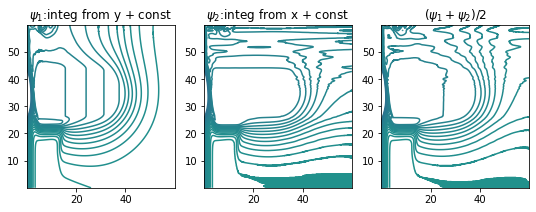

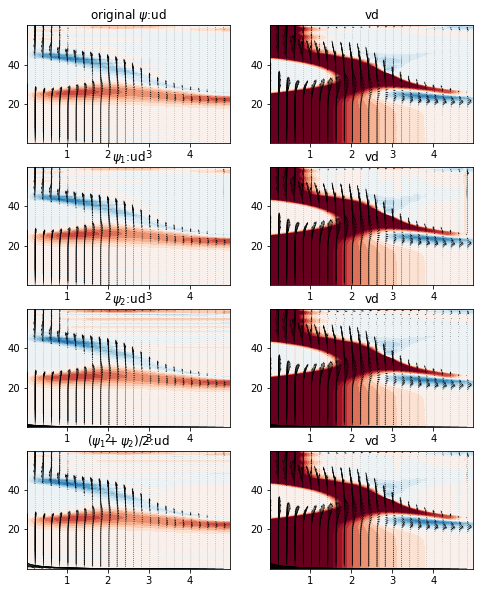

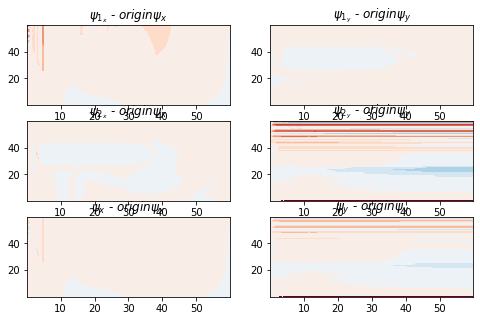

In [13]:
from matplotlib import cm
# -------- psi -------- 
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
contourf_ = ax[0].contour(
    x, y, np.mean(psi1[10::,:,:],axis=0).T, levels=np.arange(-2, 2+1e-4, 0.02, dtype=float))
ax[0].set_title('$\psi_1$:integ from y + const')
contourf_ = ax[1].contour(
    x, y, np.mean(psi2[10::,:,:],axis=0).T, levels=np.arange(-2, 2+1e-4, 0.02, dtype=float))
ax[1].set_title('$\psi_2$:integ from x + const')
contourf_ = ax[2].contour(
    x, y, np.mean(psi0[10::,:,:],axis=0).T, levels=np.arange(-2, 2+1e-4, 0.02, dtype=float))
ax[2].set_title('($\psi_1+\psi_2$)/2')

# -------- psi_x and psi_y -------- 
fig, ax = plt.subplots(4, 2, figsize=(8, 10))
# ud
ax[0,0].contourf(x[0:100], y, np.mean(-psi_y[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-.5,.5+1e-4,.01), cmap=cm.RdBu_r)
ax[0,0].set_title('original $\psi$:ud')
ax[0,0].quiver(x[0:100:4], y[::20], np.mean(-psi_y[:,0:100:4,::20],axis=0).T, np.mean(psi_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.1, color='k')

# vd
ax[0,1].contourf(x[0:100], y, np.mean(psi_x[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-1,1+1e-4,.01), cmap=cm.RdBu_r, hold=True)
ax[0,1].quiver(x[0:100:4], y[::20], np.mean(-psi_y[:,0:100:4,::20],axis=0).T, np.mean(psi_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.05, color='k')
ax[0,1].set_title('vd')

# ud
ax[1,0].contourf(x[0:100], y, np.mean(-psi1_y[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-.5,.5+1e-4,.01), cmap=cm.RdBu_r)
ax[1,0].set_title('$\psi_1$:ud')
ax[1,0].quiver(x[0:100:4], y[::20], np.mean(-psi1_y[:,0:100:4,::20],axis=0).T, np.mean(psi1_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.1, color='k')
# vd
ax[1,1].contourf(x[0:100], y, np.mean(psi1_x[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-1,1+1e-4,.01), cmap=cm.RdBu_r, hold=True)
ax[1,1].quiver(x[0:100:4], y[::20], np.mean(-psi1_y[:,0:100:4,::20],axis=0).T, np.mean(psi1_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.05, color='k')
ax[1,1].set_title('vd')

# ud
ax[2,0].contourf(x[0:100], y, np.mean(-psi2_y[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-.5,.5+1e-4,.01), cmap=cm.RdBu_r)
ax[2,0].set_title('$\psi_2$:ud')
ax[2,0].quiver(x[0:100:4], y[::20], np.mean(-psi2_y[:,0:100:4,::20],axis=0).T, np.mean(psi2_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.1, color='k')
# vd
ax[2,1].contourf(x[0:100], y, np.mean(psi2_x[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-1,1+1e-4,.01), cmap=cm.RdBu_r, hold=True)
ax[2,1].quiver(x[0:100:4], y[::20], np.mean(-psi2_y[:,0:100:4,::20],axis=0).T, np.mean(psi2_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.05, color='k')
ax[2,1].set_title('vd')

# ud
ax[-1,0].contourf(x[0:100], y, np.mean(-psi0_y[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-.5,.5+1e-4,.01), cmap=cm.RdBu_r)
ax[-1,0].set_title('($\psi_1+\psi_2$)/2:ud')
ax[-1,0].quiver(x[0:100:4], y[::20], np.mean(-psi0_y[:,0:100:4,::20],axis=0).T, np.mean(psi0_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.1, color='k')

# vd
ax[-1,1].contourf(x[0:100], y, np.mean(psi0_x[:,0:100,:],axis=0).T, vmin = -.1, vmax = .1, levels=np.arange(-1,1+1e-4,.01), cmap=cm.RdBu_r, hold=True)
ax[-1,1].quiver(x[0:100:4], y[::20], np.mean(-psi0_y[:,0:100:4,::20],axis=0).T, np.mean(psi0_x[:,0:100:4,::20],axis=0).T
            ,pivot='tail', units='xy', scale=.05, color='k')
ax[-1,1].set_title('vd')

# -------- difference of psi_x and psi_y between origins -------- 
fig,ax = plt.subplots(3,2, figsize=(8, 5))
ax[0,0].contourf(x, y, (np.mean(psi1_x,axis=0)-np.mean(psi_x,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[0,0].set_title('$\psi_{1_x}$ - $origin \psi_x$')
ax[0,1].contourf(x, y, (np.mean(psi1_y,axis=0)-np.mean(psi_y,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[0,1].set_title('$\psi_{1_y}$ - $origin \psi_y$')

ax[1,0].contourf(x, y, (np.mean(psi2_x,axis=0)-np.mean(psi_x,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[1,0].set_title('$\psi_{2_x}$ - $origin \psi_x$')
ax[1,1].contourf(x, y, (np.mean(psi2_y,axis=0)-np.mean(psi_y,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[1,1].set_title('$\psi_{2_y}$ - $origin \psi_y$')

ax[-1,0].contourf(x, y, (np.mean(psi0_x,axis=0)-np.mean(psi_x,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[-1,0].set_title('$\psi_x$ - $origin \psi_x$')
ax[-1,1].contourf(x, y, (np.mean(psi0_y,axis=0)-np.mean(psi_y,axis=0)).T, vmin = -.04, vmax = .04, levels=np.arange(-.5,.5+1e-4,.005), cmap=cm.RdBu_r)
ax[-1,1].set_title('$\psi_y$ - $origin \psi_y$')

In [14]:
# make coordinates correct: v/y means north-south, u/x means west-east 

x, y, t, d, h, v, u = extract_data(Data)

# average between the time period presumably the hydraulic control has been established
t_start = 100
t_end = 800

a, idx_ts = find_nearest(t, t_start)
a, idx_te = find_nearest(t, t_end)
d = d[idx_ts:idx_te,:,:]
v = v[idx_ts:idx_te,:,:]
u = u[idx_ts:idx_te,:,:]

u_mean = np.mean(u,axis=0).reshape((1,u.shape[1],u.shape[-1]))
v_mean = np.mean(v,axis=0).reshape((1,v.shape[1],v.shape[-1]))
d_mean = np.mean(d,axis=0).reshape((1,d.shape[1],d.shape[-1]))

psi1_mean, psi2_mean, psi0_mean, psi1_mean_x, psi1_mean_y, psi2_mean_x, psi2_mean_y, psi0_mean_x, psi0_mean_y, psi_mean_x, psi_mean_y = streamfunc_method1(x, y, u_mean, v_mean, d_mean)

In [15]:
Ber = (u**2 + v**2)/2 + d + h.reshape((1, h.shape[0], h.shape[1]))
Ber[np.where(np.isnan(d))]=np.nan
Ber = xr.DataArray(Ber, dims=['time', 'x', 'y'],  
                  coords={'time':t[idx_ts:idx_te], 
                          'x': x,
                          'y': y},
                  attrs={'long_name': 'Bernoulli function'})
psi1[d < 1e-7] = np.nan
Psi = xr.DataArray(psi1, dims=['time', 'x', 'y'],  
                  coords={'time':t[idx_ts:idx_te], 
                          'x': x,
                          'y': y},
                  attrs={'long_name': 'psi'})
div[d < 1e-7] = np.nan
Div = xr.DataArray(div, dims=['time', 'x', 'y'],  
                  coords={'time':t[idx_ts:idx_te], 
                          'x': x,
                          'y': y},
                  attrs={'long_name': 'div'})
RV =  np.gradient(v,x,axis=1) - np.gradient(u,y,axis=-1)
AV = RV - np.ones(RV.shape)
PV = AV/d
PV[d < 1e-7] = np.nan
PV = xr.DataArray(PV, dims=['time', 'x', 'y'],  
                  coords={'time':t[idx_ts:idx_te], 
                          'x': x,
                          'y': y},
                  attrs={'long_name': 'PV'})

Ber_mean = (u_mean.squeeze()**2 + v_mean.squeeze()**2)/2 + d_mean.squeeze() + h
Ber_mean[d_mean.squeeze() < 1e-7] = np.nan
Ber_mean = xr.DataArray(Ber_mean, dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'B_mean'})
div_mean[d_mean.squeeze() < 1e-7] = np.nan
Div_mean = xr.DataArray(div_mean, dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'div_mean'})
psi1_mean[d_mean < 1e-7] = np.nan
Psi_mean = xr.DataArray(psi1_mean.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'psi_mean'})
RV_mean =  np.gradient(v_mean,x,axis=1) - np.gradient(u_mean,y,axis=-1)
AV_mean = RV_mean - np.ones(RV_mean.shape)
PV_mean = AV_mean/d_mean
PV_mean[d_mean < 1e-7] = np.nan
PV_mean = xr.DataArray(PV_mean.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'PV_mean'})

psi1_mean_x[d_mean < 1e-7] = np.nan
Psi_mean_x = xr.DataArray(psi1_mean_x.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'psi_mean_x'})
psi1_mean_y[d_mean < 1e-7] = np.nan
Psi_mean_y = xr.DataArray(psi1_mean_y.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'psi_mean_y'})
psi_mean_x[d_mean < 1e-7] = np.nan
Psi_mean_x_ori = xr.DataArray(psi_mean_x.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'original psi_mean_x'})
psi_mean_y[d_mean < 1e-7] = np.nan
Psi_mean_y_ori = xr.DataArray(psi_mean_y.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'original psi_mean_y'})
u_mean[d_mean < 1e-7] = np.nan
u_mean = xr.DataArray(u_mean.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'u_mean'})
v_mean[d_mean < 1e-7] = np.nan
v_mean = xr.DataArray(v_mean.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'v_mean'})
d_mean[d_mean < 1e-7] = np.nan
d_mean = xr.DataArray(d_mean.squeeze(), dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'd_mean'})
h = xr.DataArray(h, dims=['x', 'y'],  
                  coords={'x': x,
                          'y': y},
                  attrs={'long_name': 'h'})

Data_ = xr.Dataset({'Ber': (['time', 'x', 'y'], Ber),
                    'Psi': (['time', 'x', 'y'], Psi),
                    'PV': (['time', 'x', 'y'], PV),
                    'Div': (['time', 'x', 'y'], Div),
                    'Ber_mean': (['x', 'y'], Ber_mean),
                    'Psi_mean': (['x', 'y'], Psi_mean),
                    'Psi_mean_x': (['x', 'y'], Psi_mean_x),
                    'Psi_mean_y': (['x', 'y'], Psi_mean_y),                    
                    'Psi_mean_x_ori': (['x', 'y'], Psi_mean_x_ori),
                    'Psi_mean_y_ori': (['x', 'y'], Psi_mean_y_ori),
                    'PV_mean': (['x', 'y'], PV_mean),
                    'Div_mean': (['x', 'y'], Div_mean),
                    'v_mean': (['x', 'y'], v_mean), 
                    'u_mean': (['x', 'y'], u_mean),
                    'd_mean': (['x', 'y'], d_mean),
                    'h': (['x', 'y'], h),},
                   coords={'time': t[idx_ts:idx_te], 
                           'x': x,
                           'y': y},
                   attrs={'title': 'Processed data',
                          'description': 'Bernoulli function, Potential vorticity, Stream function, Transport divergence'})


In [16]:
# choices of streamlines

S_0 = np.arange(-.5,-.4,.02)
S_4 = np.arange(-.38,-.26,.02)
S_2 = np.arange(-.1,0,.02)

In [17]:
def project_streamline(x, y, psi, yc, psi0, channel=True):
    """ circuit surround the western part of the channel and the island, defined by psi=psi0 
    channel = True: through channel; False: along the island """
    from scipy.interpolate import interp1d


    
    if channel == True:
        a, idx_yu = find_nearest(y, 20)
        a, idx_yd = find_nearest(y, 50)
    else:
        a, idx_yu = find_nearest(y, 8)
        a, idx_yd = find_nearest(y, 50)
        
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    # circuit: through channel
    y_ = np.copy(y[idx_yu:idx_yd])
    x_ = np.zeros(len(y_),) + np.nan
    psi_ = psi[:, idx_yu:idx_yd]
    for i in range(len(y_)):
        f = interp1d(psi_[:, i], x, bounds_error=False, fill_value=np.nan)
        x_[i] = f(psi0)
    x_ch = x_[~np.isnan(x_)]
    y_ch = y_[~np.isnan(x_)]

    # north part
    a, idx_y = find_nearest(y, y_ch[x_ch.argmax()])
    a, idx_x = find_nearest(x, x_ch.max())
    x1_ = np.copy(x[0:idx_x+2])
    y1_ = np.zeros(len(x1_),) + np.nan
    for i in range(len(x1_)):
        f = interp1d(psi[i, idx_y:idx_yd].squeeze(
        ), y[idx_y:idx_yd], bounds_error=False, fill_value=np.nan)
        y1_[i] = f(psi0)
    # south part
    x2_ = np.copy(x1_)
    y2_ = np.zeros(len(x2_),) + np.nan
    for i in range(len(x1_)):
        if len(np.where(y < y1_[i])[0]) > 0:
            psi_ = psi[i, np.where(y < y1_[i])].squeeze()
            y2__ = y[np.where(y < y1_[i])]
            f = interp1d(psi_[0:psi_.argmin(
            )+1], y2__[0:psi_.argmin()+1], bounds_error=False, fill_value=np.nan)
        else:
            f = interp1d(psi[i, idx_yu:idx_y].squeeze(
            ), y[idx_yu:idx_y], bounds_error=False, fill_value=np.nan)
        y2_[i] = f(psi0)

    x1_accept = x1_[~np.isnan(y1_)][::-1]
    y1_accept = y1_[~np.isnan(y1_)][::-1]
    x2_accept = x2_[~np.isnan(y2_)]
    y2_accept = y2_[~np.isnan(y2_)]

    if y1_accept[0]-y2_accept[-1] > dy:
        y3_ = np.arange(y2_accept[-1]+dy, y1_accept[0]+1e-3, dy)
        x3_ = np.zeros(len(y3_),) + np.nan
        psi_ = np.zeros((len(x), len(y3_))) + np.nan
        for i in range(len(x)):
            f = interp1d(y, psi[i, :].squeeze(),
                         bounds_error=False, fill_value=np.nan)
            psi_[i, :] = f(y3_)
        for i in range(len(y3_)):
            x__ = x2_accept[np.where(y2_accept > y3_[i])]
            if len(x__) > 0:
                f = interp1d(psi_[np.where(x > x__[-1]), i].squeeze(),
                             x[np.where(x > x__[-1])], bounds_error=False, fill_value=np.nan)
            else:
                f = interp1d(psi_[:, i].squeeze(), x,
                             bounds_error=False, fill_value=np.nan)
            x3_[i] = f(psi0)

    x3_accept = x3_[~np.isnan(y3_)]
    y3_accept = y3_[~np.isnan(y3_)]

    y_out = np.concatenate((y2_accept, y3_accept, y1_accept))
    x_out = np.concatenate((x2_accept, x3_accept, x1_accept))

    return x_out, y_out

In [18]:
def data_streamline(Data_, x, y, yc, psi0, channel=True):
    """ interpolated data along the streamline 
        for now only process mean data """
    
    # circuit
    x_out, y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, psi0, channel)
    
    Ber_ = np.zeros((len(x_out), )) + np.nan
    PV_ = np.zeros((len(x_out), )) + np.nan
    Psi_ = np.zeros((len(x_out), )) + np.nan
    Div_ = np.zeros((len(x_out), )) + np.nan
    
    Psi_x_ = np.zeros((len(x_out), )) + np.nan
    Psi_y_ = np.zeros((len(x_out), )) + np.nan
    Psi_x_ori_ = np.zeros((len(x_out), )) + np.nan
    Psi_y_ori_ = np.zeros((len(x_out), )) + np.nan

    u_ = np.zeros((len(x_out), )) + np.nan
    v_ = np.zeros((len(x_out), )) + np.nan
    d_ = np.zeros((len(x_out), )) + np.nan
    h_ = np.zeros((len(x_out), )) + np.nan

    for i in range(len(x_out)):
        Ber_[i] = Data_.Ber_mean.interp(x=x_out[i], y=y_out[i])
        PV_[i] = Data_.PV_mean.interp(x=x_out[i], y=y_out[i])
        Psi_[i] = Data_.Psi_mean.interp(x=x_out[i], y=y_out[i])
        Div_[i] = Data_.Div_mean.interp(x=x_out[i], y=y_out[i])
        
        Psi_x_[i] = Data_.Psi_mean_x.interp(x=x_out[i], y=y_out[i])
        Psi_y_[i] = Data_.Psi_mean_y.interp(x=x_out[i], y=y_out[i])
        Psi_x_ori_[i] = Data_.Psi_mean_x_ori.interp(x=x_out[i], y=y_out[i])
        Psi_y_ori_[i] = Data_.Psi_mean_y_ori.interp(x=x_out[i], y=y_out[i])

        u_[i] = Data_.u_mean.interp(x=x_out[i], y=y_out[i])
        v_[i] = Data_.v_mean.interp(x=x_out[i], y=y_out[i])
        d_[i] = Data_.d_mean.interp(x=x_out[i], y=y_out[i])
        h_[i] = Data_.h.interp(x=x_out[i], y=y_out[i])

    # distance
    dx = np.diff(x_out)
    dy = np.diff(y_out)
    dis = np.append([0], np.cumsum(np.sqrt(dx**2 + dy**2)))

    # build DataArray
    x_out = xr.DataArray(x_out, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'x'})
    y_out = xr.DataArray(y_out, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'y'})
    
    Ber_ = xr.DataArray(Ber_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'Bernoulli function'})
    PV_ = xr.DataArray(PV_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'Potential vorticity'})
    Div_ = xr.DataArray(Div_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'Transport divergence'})    
    Psi_ = xr.DataArray(Psi_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'Stream function'})    
    Psi_x_ = xr.DataArray(Psi_x_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'psi_x'})    
    Psi_y_ = xr.DataArray(Psi_y_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'psi_y'})    
    Psi_x_ori_ = xr.DataArray(Psi_x_ori_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'psi_x_ori'})    
    Psi_y_ori_ = xr.DataArray(Psi_y_ori_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'psi_y_ori'})  
    u_ = xr.DataArray(u_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'u'})
    v_ = xr.DataArray(v_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'v'})
    d_ = xr.DataArray(d_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'd'})    
    h_ = xr.DataArray(h_, dims=['dis'],
                        coords={'dis': dis},
                        attrs={'long_name': 'h'})    
    
    data_ = xr.Dataset({'x_out': (['dis'], x_out),
                        'y_out': (['dis'], y_out),
                        'Ber_': (['dis'], Ber_),
                        'PV_': (['dis'], PV_),
                        'Div_': (['dis'], Div_),
                        'Psi_': (['dis'], Psi_),
                        'Psi_x_': (['dis'], Psi_x_),
                        'Psi_y_': (['dis'], Psi_y_),
                        'Psi_x_ori_': (['dis'], Psi_x_ori_),
                        'Psi_y_ori_': (['dis'], Psi_y_ori_),
                        'u_': (['dis'], u_),
                        'v_': (['dis'], v_),
                        'd_': (['dis'], d_),
                        'h_': (['dis'], h_)},
                       coords={'dis': dis},
                       attrs={'title': 'Data at streamline',
                              'description': 'Data interpolated onto a picked streamline'})
    return data_


In [19]:
idx_s0 = 2
idx_s2 = 0
idx_s4 = 4
print('S0: ', S_0[idx_s0], 'S2: ', S_2[idx_s2], 'S4: ', S_4[idx_s4])

S0:  -0.45999999999999996 S2:  -0.1 S4:  -0.29999999999999993


/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

Text(0, 0.5, 'h+d')

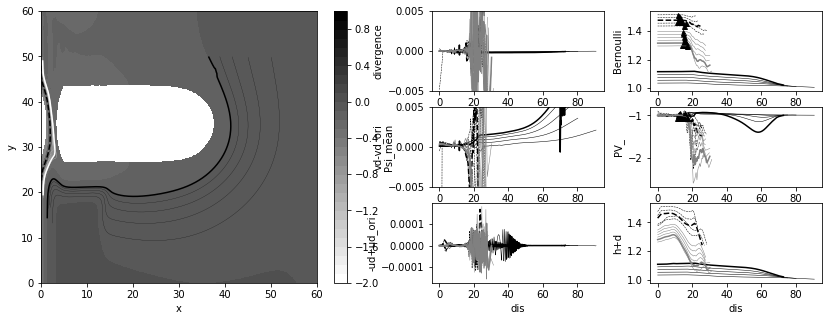

In [20]:
# visulize divergence along streamlines
yc = 35
from matplotlib import cm
from scipy.interpolate import interp1d
cmap1=cm.RdBu_r
cmap1.set_bad('gray',1.)
cmap1.set_over('white',1.)

from matplotlib import gridspec
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(3, 3,
                       width_ratios=[2,1,1],
                       height_ratios=[1,1,1]
                       )

ax1 = plt.subplot(gs[:,0])
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[-1,1])

ax6 = plt.subplot(gs[0,-1])
ax7 = plt.subplot(gs[1,-1])
ax8 = plt.subplot(gs[-1,-1])

Data_.Psi_mean.T.plot(cmap=cm.binary, vmin=-0.8, vmax=0, levels=np.arange(-2.0, 1.0+1e-4, 0.1, dtype=float), ax=ax1)#, add_colorbar=False)
for i in range(len(S_0)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_0[i])
    if i == idx_s0:
        ax1.plot(x_out,y_out,'k--')
    else:
        ax1.plot(x_out,y_out,'k--',linewidth=.2)
for i in range(len(S_2)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_2[i], False)
    if i == idx_s2:
        ax1.plot(x_out,y_out,'k')
    else:
        ax1.plot(x_out,y_out,'k',linewidth=.2)
for i in range(len(S_4)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_4[i])
    if i == idx_s4:
        ax1.plot(x_out,y_out,'w')
    else:
        ax1.plot(x_out,y_out,'w',linewidth=.2)

for i in range(len(S_0)):
    Data_s0 = data_streamline(Data_, x, y, yc, S_0[i])
    if i == idx_s0:
        lw = 1.5
        ms = 10
    else:
        lw = .5
        ms = 5
    Data_s0.Div_.plot(ax=ax3,color='k',linestyle='--',linewidth=lw)
    (Data_s0.Psi_x_-Data_s0.Psi_x_ori_).plot(ax=ax4,color='k',linestyle='--',linewidth=lw)
    (Data_s0.Psi_y_-Data_s0.Psi_y_ori_).plot(ax=ax5,color='k',linestyle='--',linewidth=lw)
    Data_s0.Ber_.plot(ax=ax6,color='k',linestyle='--',linewidth=lw)
    f1 = interp1d(Data_s0.y_out, Data_s0.dis, bounds_error=False, fill_value=np.nan)
    f2 = interp1d(Data_s0.dis, Data_s0.Ber_, bounds_error=False, fill_value=np.nan)
    ax6.plot(f1(35),f2(f1(35)),'k^',markersize=ms)
#     (Data_s0.h_+Data_s0.d_).plot(ax=ax6,color='k',linestyle='--',linewidth=.5)
    Data_s0.PV_.plot(ax=ax7,color='k',linestyle='--',linewidth=lw)
    f1 = interp1d(Data_s0.y_out, Data_s0.dis, bounds_error=False, fill_value=np.nan)
    f2 = interp1d(Data_s0.dis, Data_s0.PV_, bounds_error=False, fill_value=np.nan)
    ax7.plot(f1(35),f2(f1(35)),'k^',markersize=ms)
    (Data_s0.h_+Data_s0.d_).plot(ax=ax8,color='k',linestyle='--',linewidth=lw)
    
for i in range(len(S_2)):
    Data_s2 = data_streamline(Data_, x, y, yc, S_2[i], False)
    if i == idx_s2:
        lw = 1.5
        ms = 10
    else:
        lw = .5
        ms = 5    
    Data_s2.Div_.plot(ax=ax3,color='k',linestyle='-',linewidth=lw)
    (Data_s2.Psi_x_-Data_s2.Psi_x_ori_).plot(ax=ax4,color='k',linestyle='-',linewidth=lw)
    (Data_s2.Psi_y_-Data_s2.Psi_y_ori_).plot(ax=ax5,color='k',linestyle='-',linewidth=lw)
    Data_s2.Ber_.plot(ax=ax6,color='k',linestyle='-',linewidth=lw)
#     (Data_s2.h_+Data_s2.d_).plot(ax=ax6,color='k',linestyle='-',linewidth=.5)
    Data_s2.PV_.plot(ax=ax7,color='k',linestyle='-',linewidth=lw)
    (Data_s2.h_+Data_s2.d_).plot(ax=ax8,color='k',linestyle='-',linewidth=lw)

for i in range(len(S_4)):
    Data_s4 = data_streamline(Data_, x, y, yc, S_4[i])
    if i == idx_s4:
        lw = 1.5
        ms = 10
    else:
        lw = .5
        ms = 5    
    Data_s4.Div_.plot(ax=ax3,color='.5',linestyle='-',linewidth=lw)
    (Data_s4.Psi_x_-Data_s4.Psi_x_ori_).plot(ax=ax4,color='.5',linestyle='-',linewidth=lw)
    (Data_s4.Psi_y_-Data_s4.Psi_y_ori_).plot(ax=ax5,color='.5',linestyle='-',linewidth=lw)
    Data_s4.Ber_.plot(ax=ax6,color='.5',linestyle='-',linewidth=lw)
    f1 = interp1d(Data_s4.y_out, Data_s4.dis, bounds_error=False, fill_value=np.nan)
    f2 = interp1d(Data_s4.dis, Data_s4.Ber_, bounds_error=False, fill_value=np.nan)
    ax6.plot(f1(35),f2(f1(35)),'k^',markersize=ms)
#     (Data_s4.h_+Data_s4.d_).plot(ax=ax6,color='.5',linestyle='-',linewidth=.5)
    Data_s4.PV_.plot(ax=ax7,color='.5',linestyle='-',linewidth=lw)
    f1 = interp1d(Data_s4.y_out, Data_s4.dis, bounds_error=False, fill_value=np.nan)
    f2 = interp1d(Data_s4.dis, Data_s4.PV_, bounds_error=False, fill_value=np.nan)
    ax7.plot(f1(35),f2(f1(35)),'k^',markersize=ms)
    (Data_s4.h_+Data_s4.d_).plot(ax=ax8,color='.5',linestyle='-',linewidth=lw)

ax3.set_ylabel('divergence')
ax3.set_ylim([-5e-3,5e-3])
ax4.set_ylabel('vd-vd_ori')
ax4.set_ylim([-5e-3,5e-3])
ax5.set_ylabel('-ud+ud_ori')
ax6.set_ylabel('Bernoulli')
ax8.set_ylabel('h+d')

In [21]:
def energy_budget(x1_all, y3_all, Data_s2, Data_s4, Data_):
    # all choices of x1 and y3:
    PV_flux_s1_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    PV_flux_s3_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    Ber_s2_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    Ber_s4_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    Diss_s2_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    Diss_s3_all = np.zeros((len(x1_all),len(y3_all))) + np.nan
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    for i in range(len(x1_all)):
        x1 = x1_all[i]
        a, idx_s1_s4 = find_nearest(Data_s4.x_out, x1)
        a, idx_s1_s2 = find_nearest(Data_s2.x_out, x1)
        ax.plot(Data_s4.x_out[idx_s1_s4], Data_s4.y_out[idx_s1_s4], 'k.')
        ax.plot(Data_s2.x_out[idx_s1_s2], Data_s2.y_out[idx_s1_s2], 'r.')   
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        y1_ = np.arange(Data_s2.y_out[idx_s1_s2], Data_s4.y_out[idx_s1_s4]+1e-3, dy)
        if y1_[-1]<Data_s4.y_out[idx_s1_s4]:
            y1_ = np.concatenate((y1_,Data_s4.y_out[idx_s1_s4].data.reshape(1,)))
        x1_ = np.zeros(len(y1_),) + x1
        flux_x = np.multiply(Data_.PV_mean,-Data_.Psi_mean_y_ori).interp(x=x1)
        PV_flux_s1_all[i,:]=-flux_x.interp(y=y1_).integrate("y")

        for j in range(len(y3_all)):
            y3=y3_all[j]
            a, idx_s3_s4 = find_nearest(Data_s4.y_out, y3)
            a, idx_s3_s2 = find_nearest(Data_s2.y_out, y3)
            ax.plot(Data_s4.x_out[idx_s3_s4], Data_s4.y_out[idx_s3_s4], 'k.')
            ax.plot(Data_s2.x_out[idx_s3_s2], Data_s2.y_out[idx_s3_s2], 'r.')   
            dx = x[1]-x[0]
            dy = y[1]-y[0]
            x3_ = np.arange(Data_s4.x_out[idx_s3_s4], Data_s2.x_out[idx_s3_s2]+1e-3, dx)
            if x3_[-1]<Data_s2.x_out[idx_s3_s2]:
                x3_ = np.concatenate((x3_,Data_s2.x_out[idx_s3_s2].data.reshape(1,)))
            y3_ = np.zeros(len(x3_),) + y3
            flux_y = np.multiply(Data_.PV_mean,Data_.Psi_mean_x_ori).interp(y=y3)
            PV_flux_s3_all[:,j]=flux_y.interp(x=x3_).integrate("x") 

            # Bernoulli
            Ber_s2_all[i,j] = Data_s2.Ber_[idx_s3_s2].data-Data_s2.Ber_[idx_s1_s2].data
            Ber_s4_all[i,j] = Data_s4.Ber_[idx_s3_s4].data-Data_s4.Ber_[idx_s1_s4].data

            # compute frictional dissipation, Cb=.2 only for x>15
            # alpng s2
            Cb = np.zeros(Data_s2.dis.shape)
            Cb[np.where(Data_s2.x_out > 15)] = 0.2
            Diss_s2_all[i,j] = integrate.cumtrapz(Cb[idx_s1_s2:idx_s3_s2]*Data_s2.u_[idx_s1_s2:idx_s3_s2], Data_s2.x_out[idx_s1_s2:idx_s3_s2], initial=0)[-1] +\
                       integrate.cumtrapz(Cb[idx_s1_s2:idx_s3_s2]*Data_s2.v_[idx_s1_s2:idx_s3_s2], Data_s2.y_out[idx_s1_s2:idx_s3_s2], initial=0)[-1]

            # along s3
            Cb = np.zeros(x3_.shape)
            Cb[np.where(x3_ > 15)] = 0.2
            Diss_s3_all[i,j] = (Cb*Data_.u_mean.interp(y=y3).interp(x=x3_))[::-1].integrate("x").data
            
    left = PV_flux_s1_all + PV_flux_s3_all
    right = -Ber_s4_all - (Diss_s2_all+Diss_s3_all)

    return PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left, right

In [22]:
def energy_plot(x1_all, y3_all, PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left, right):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
    cs1 = ax[0, 0].contour(x1_all, y3_all, Ber_s2_all.T)
    ax[0, 0].clabel(cs1, inline=1, fontsize=10)
    ax[0, 0].set_title('Ber s2')
    print('Ber s2: ', str(np.nanmean(Ber_s2_all)))
    cs2 = ax[0, 1].contour(x1_all, y3_all, Ber_s4_all.T)
    ax[0, 0].clabel(cs2, inline=1, fontsize=10)
    ax[0, 1].set_title('Ber s4')
    print('Ber s4: ', str(np.nanmean(Ber_s4_all)))

    cs3 = ax[1, 0].contour(x1_all, y3_all, PV_flux_s1_all.T)
    ax[1, 0].clabel(cs3, inline=1, fontsize=10)
    ax[1, 0].set_title('PV flux s1')
    print('PV flux s1: ', str(np.nanmean(PV_flux_s1_all)))
    cs4 = ax[1, 1].contour(x1_all, y3_all, PV_flux_s3_all.T)
    ax[1, 0].clabel(cs4, inline=1, fontsize=10)
    ax[1, 1].set_title('PV flux s3')
    print('PV flux s3: ', str(np.nanmean(PV_flux_s3_all)))

    cs5 = ax[2, 0].contour(x1_all, y3_all, Diss_s2_all.T)
    ax[2, 0].clabel(cs5, inline=1, fontsize=10)
    ax[2, 0].set_title('Diss s2')
    print('Diss s2: ', str(np.nanmean(Diss_s2_all)))
    cs6 = ax[2, 1].contour(x1_all, y3_all, Diss_s3_all.T)
    ax[2, 0].clabel(cs6, inline=1, fontsize=10)
    ax[2, 1].set_title('Diss s3')
    print('Diss s3: ', str(np.nanmean(Diss_s3_all)))

    cs7 = ax[0, -1].contour(x1_all, y3_all, left.T)
    ax[0, -1].clabel(cs7, inline=1, fontsize=10)
    ax[0, -1].set_title('left terms')
    print('left terms: ', str(np.nanmean(left)))
    cs8 = ax[1, -1].contour(x1_all, y3_all, right.T)
    ax[1, -1].clabel(cs8, inline=1, fontsize=10)
    ax[1, -1].set_title('right terms')
    print('right terms: ', str(np.nanmean(right)))

    cs9 = ax[-1,-1].contourf(x1_all, y3_all, left.T-right.T,vmin=-.1,vmax=.1, levels=np.arange(-.1, .1+1e-4, 0.001, dtype=float), cmap=cm.RdBu_r, add_colorbar=True)
    ax[-1, -1].set_title('left-right terms')
    print('left - right terms (median): ', str(np.nanmedian(left-right)))
    print('left - right terms (mean): ', str(np.nanmean(left-right)), '+-', str(np.nanstd(left-right)))


/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less


Ber s2:  -0.08221578120435413
Ber s4:  -0.14480856286357227
PV flux s1:  0.2000793594155597
PV flux s3:  -0.1871523680869962
Diss s2:  0.11130189178577168
Diss s3:  0.027801470950659962
left terms:  0.012926991328563528
right terms:  0.005705200127140639


/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'add_colorbar'


left - right terms (median):  0.012804098543331685
left - right terms (mean):  0.007221791201422887 +- 0.05688580363813663


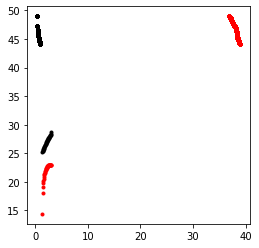

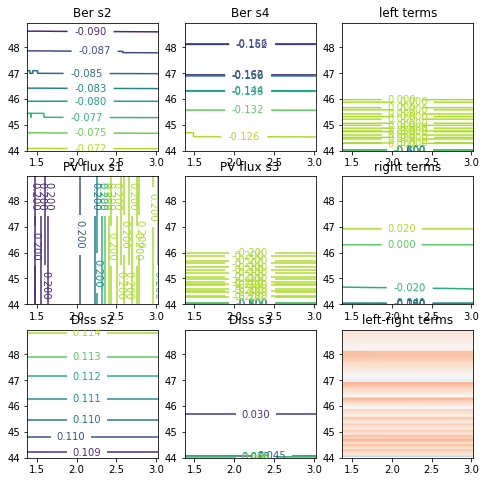

In [23]:
Data_s0 = data_streamline(Data_, x, y, yc, S_0[idx_s0])    
Data_s2 = data_streamline(Data_, x, y, yc, S_2[idx_s2], False)        
Data_s4 = data_streamline(Data_, x, y, yc, S_4[idx_s4])

dx = x[1]-x[0]
dy = y[1]-y[0]
x1_all = np.arange(np.array((Data_s4.x_out.min().data, Data_s2.x_out.min().data)).max(), Data_s4.x_out.max().data+1e-3, dx)
y3_all = np.arange(44, Data_s4.y_out.max().data+1e-3, dy)

PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left, right = energy_budget(x1_all, y3_all, Data_s2, Data_s4, Data_)
energy_plot(x1_all, y3_all, PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left, right)

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

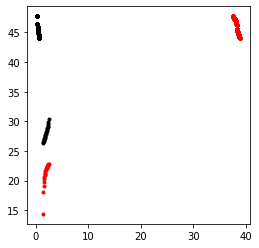

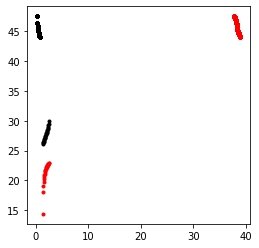

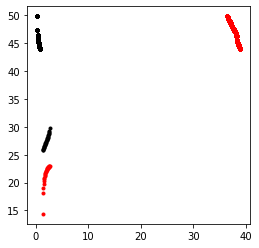

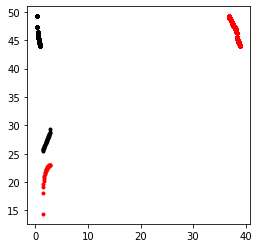

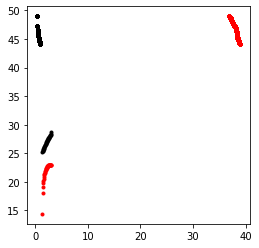

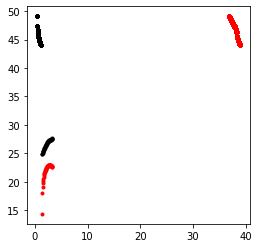

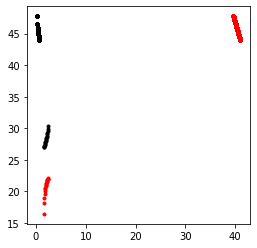

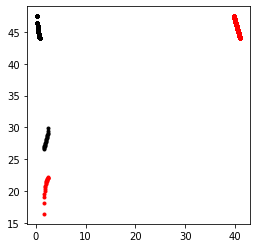

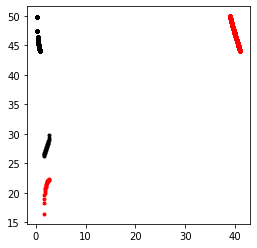

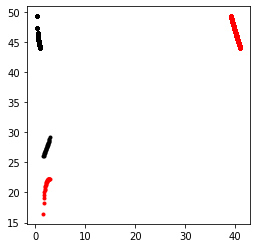

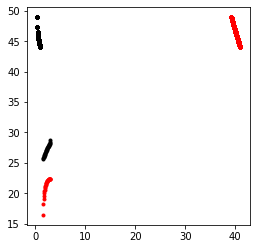

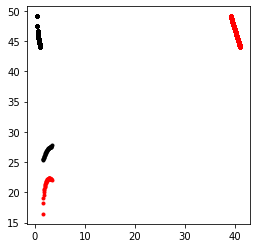

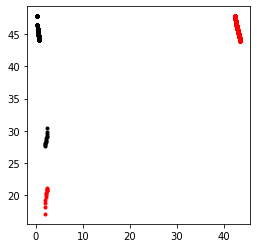

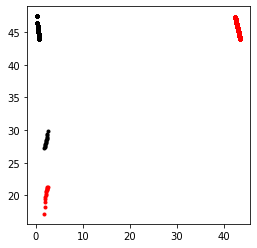

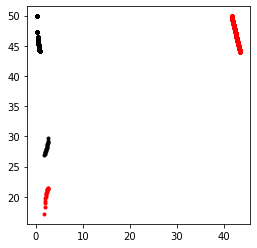

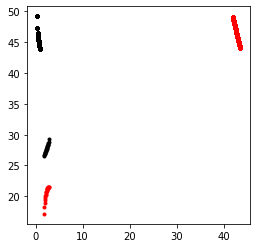

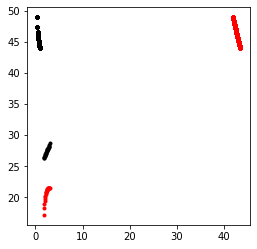

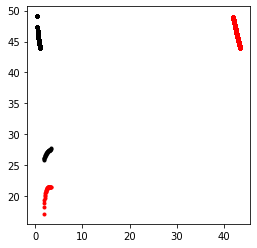

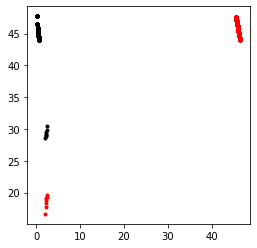

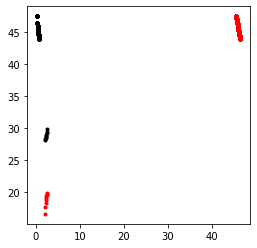

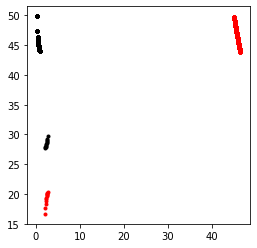

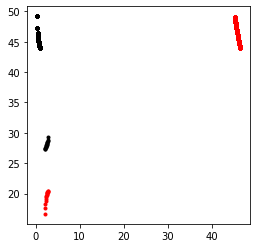

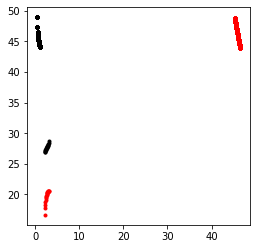

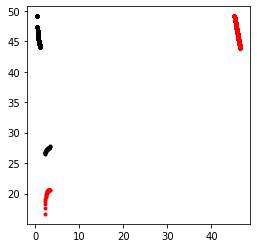

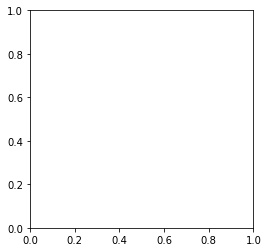

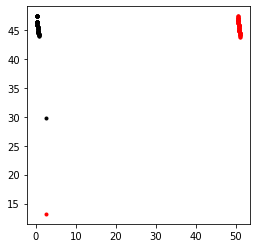

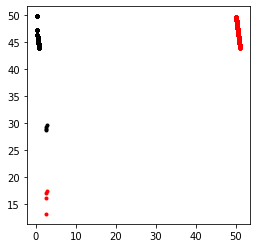

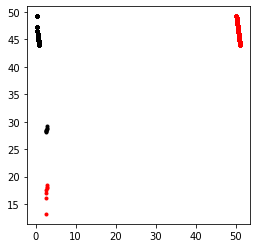

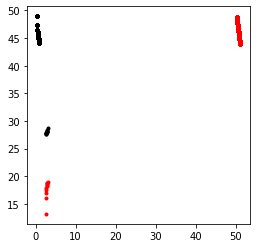

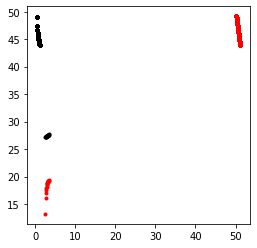

In [24]:
Ber_s2 = np.zeros((5, len(S_2), len(S_4)))
Ber_s4 = np.zeros((5, len(S_2), len(S_4)))
PVf_s1 = np.zeros((5, len(S_2), len(S_4)))
PVf_s3 = np.zeros((5, len(S_2), len(S_4)))
Diss_s2 = np.zeros((5, len(S_2), len(S_4)))
Diss_s3 = np.zeros((5, len(S_2), len(S_4)))
lf = np.zeros((5, len(S_2), len(S_4)))
rt = np.zeros((5, len(S_2), len(S_4)))
diff_lr = np.zeros((5, len(S_2), len(S_4)))

for i in range(len(S_2)):
    Data_s2 = data_streamline(Data_, x, y, yc, S_2[i], False)
    for j in range(len(S_4)):
        Data_s4 = data_streamline(Data_, x, y, yc, S_4[j])
        
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        x1_all = np.arange(np.array((Data_s4.x_out.min().data, Data_s2.x_out.min().data)).max(), Data_s4.x_out.max().data+1e-3, dx)
        y3_all = np.arange(44, Data_s4.y_out.max().data+1e-3, dy)       
        
        PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left_all, right_all = energy_budget(x1_all, y3_all, Data_s2, Data_s4, Data_)
#         energy_plot(x1_all, y3_all, PV_flux_s1_all, PV_flux_s3_all, Ber_s2_all, Ber_s4_all, Diss_s2_all, Diss_s3_all, left_all, right_all)
        
        Ber_s2[0, i, j] = np.nanmean(Ber_s2_all)
        Ber_s2[1, i, j] = np.nanpercentile(Ber_s2_all, 10)
        Ber_s2[2, i, j] = np.nanpercentile(Ber_s2_all, 90)
        Ber_s2[3, i, j] = np.nanmedian(Ber_s2_all)
        Ber_s2[-1, i, j] = np.nanstd(Ber_s2_all)
        
        Ber_s4[0, i, j] = np.nanmean(Ber_s4_all)
        Ber_s4[1, i, j] = np.nanpercentile(Ber_s4_all, 10)
        Ber_s4[2, i, j] = np.nanpercentile(Ber_s4_all, 90)
        Ber_s4[3, i, j] = np.nanmedian(Ber_s4_all)
        Ber_s4[-1, i, j] = np.nanstd(Ber_s4_all)
        
        PVf_s1[0, i, j] = np.nanmean(PV_flux_s1_all)
        PVf_s1[1, i, j] = np.nanpercentile(PV_flux_s1_all, 10)
        PVf_s1[2, i, j] = np.nanpercentile(PV_flux_s1_all, 90)
        PVf_s1[3, i, j] = np.nanmedian(PV_flux_s1_all)
        PVf_s1[-1, i, j] = np.nanstd(PV_flux_s1_all)
        
        PVf_s3[0, i, j] = np.nanmean(PV_flux_s3_all)
        PVf_s3[1, i, j] = np.nanpercentile(PV_flux_s3_all, 10)
        PVf_s3[2, i, j] = np.nanpercentile(PV_flux_s3_all, 90)
        PVf_s3[3, i, j] = np.nanmedian(PV_flux_s3_all)
        PVf_s3[-1, i, j] = np.nanstd(PV_flux_s3_all)
        
        Diss_s2[0, i, j] = np.nanmean(Diss_s2_all)
        Diss_s2[1, i, j] = np.nanpercentile(Diss_s2_all, 10)
        Diss_s2[2, i, j] = np.nanpercentile(Diss_s2_all, 90)
        Diss_s2[3, i, j] = np.nanmedian(Diss_s2_all)
        Diss_s2[-1, i, j] = np.nanstd(Diss_s2_all)
        
        Diss_s3[0, i, j] = np.nanmean(Diss_s3_all)
        Diss_s3[1, i, j] = np.nanpercentile(Diss_s3_all, 10)
        Diss_s3[2, i, j] = np.nanpercentile(Diss_s3_all, 90)
        Diss_s3[3, i, j] = np.nanmedian(Diss_s3_all)
        Diss_s3[-1, i, j] = np.nanstd(Diss_s3_all)
        
        lf[0, i, j] = np.nanmean(left_all)
        lf[1, i, j] = np.nanpercentile(left_all, 10)
        lf[2, i, j] = np.nanpercentile(left_all, 90)
        lf[3, i, j] = np.nanmedian(left_all)
        lf[-1, i, j] = np.nanstd(left_all)
        
        rt[0, i, j] = np.nanmean(right_all)
        rt[1, i, j] = np.nanpercentile(right_all, 10)
        rt[2, i, j] = np.nanpercentile(right_all, 90)
        rt[3, i, j] = np.nanmedian(right_all)
        rt[-1, i, j] = np.nanstd(right_all)
        
        diff_lr[0, i, j] = np.nanmean(left_all-right_all)
        diff_lr[1, i, j] = np.nanpercentile(left_all-right_all, 10)
        diff_lr[2, i, j] = np.nanpercentile(left_all-right_all, 90) 
        diff_lr[3, i, j] = np.nanmedian(left_all-right_all)
        diff_lr[-1, i, j] = np.nanstd(left_all-right_all)

In [ ]:
energy = pd.DataFrame({'$-\int_{S_1}q(ud)\mathrm{d}y$': PVf_s1[0, :, :].flatten(), '$\int_{S_3}q(vd)\mathrm{d}x$': PVf_s3[0, :, :].flatten(),
                       '$\delta{B}$': -Ber_s4[0, :, :].flatten(),
                       '$-\int_{S_2}\lambda\mathbf{u}\cdot\mathbf{l}\mathrm{d}s$': -Diss_s2[0, :, :].flatten(), '$\int_{S_3}\lambda u\mathrm{d}x$': -Diss_s3[0, :, :].flatten(),
                       'LH': lf[0, :, :].flatten(), 'RH': rt[0, :, :].flatten(),
                       'LH - RH': diff_lr[0, :, :].flatten()})#, '$\delta{B}|_{S_4}$': Ber_s4[0, :, :].flatten()})
energy_all = pd.DataFrame({'Pvf_s1': PVf_s1.flatten(), 'PVf_s3': PVf_s3.flatten(),
                       'Ber_s2': Ber_s2.flatten(), 'Ber_s4': Ber_s4.flatten(),
                       'Diss_s2': Diss_s2.flatten(), 'Diss_s3': Diss_s3.flatten(),
                       'lf': lf.flatten(), 'rt': rt.flatten(),
                       'diff_lr': diff_lr.flatten()})
energy.to_csv('../data/energy.csv')

# Fig. 10

In [ ]:
Data_s2 = data_streamline(Data_, x, y, yc, S_2[idx_s2], False)        
Data_s4 = data_streamline(Data_, x, y, yc, S_4[idx_s4])
Data_s0 = data_streamline(Data_, x, y, yc, S_0[idx_s0])

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

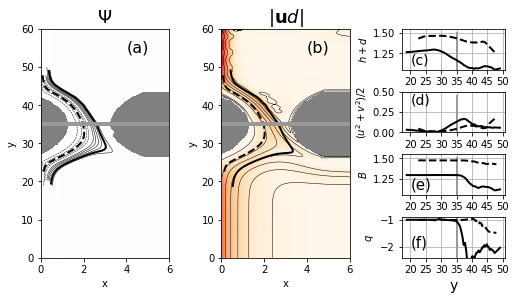

In [25]:
from matplotlib import cm
cmap1=cm.OrRd
cmap1.set_bad('gray',1.)
cmap2=cm.binary_r
cmap2.set_bad('gray',1.)

from matplotlib import gridspec
fig = plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(4, 3, width_ratios=[1,1,.8])

ax1 = plt.subplot(gs[:,0])
ax2 = plt.subplot(gs[:,1])

ax4 = plt.subplot(gs[2,-1])
ax6 = plt.subplot(gs[-1,-1], sharex=ax4)
ax3 = plt.subplot(gs[0,-1], sharex=ax4)
ax5 = plt.subplot(gs[1,-1], sharex=ax4)

((Data_.u_mean**2+Data_.v_mean**2)**.5*Data_.d_mean).T.plot(cmap=cmap2, vmin=-100, vmax=1, add_colorbar=False, ax=ax1)
for i in range(len(S_0)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_0[i])
    if i == idx_s0:
        ax1.plot(x_out,y_out,'k--',lw=2)
    else:
        ax1.plot(x_out,y_out,'k--',lw=.5)
for i in range(len(S_4)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_4[i])
    if i == idx_s4:
        ax1.plot(x_out,y_out,'k',lw=2)
    else:
        ax1.plot(x_out,y_out,'k',lw=.5)
ax1.set_xlim([0, 6])
ax1.set_ylim([0, 60])
ax1.set_title('$\Psi$', fontsize= 18)
ax1.plot([0, 10], [35, 35], color='0.6', lw=4)

((Data_.u_mean**2+Data_.v_mean**2)**.5*Data_.d_mean).T.plot(cmap=cmap1, vmin=0, vmax=1, add_colorbar=False, ax=ax2)#, cbar_kwargs={'label': ''})
(Data_.d_mean+Data_.h).T.plot.contour(levels=np.arange(0, 2+1e-4, 0.08, dtype=float), colors='k', linewidths=.5, add_colorbar=False, ax=ax2)
ax2.plot(Data_s0.x_out,Data_s0.y_out,'k--', lw=2)
# ax2.plot(Data_s2.x_out,Data_s2.y_out,'.5',lw=2)
ax2.plot(Data_s4.x_out,Data_s4.y_out, 'k', lw=2)
ax2.plot([0, 10], [35, 35], color='0.6', lw=4)
ax2.set_title('$|\mathbf{u}d|$', fontsize= 18)
ax2.set_xlim([0, 6])
ax2.set_ylim([0, 60])
ax2.set_xticks(np.around(np.arange(0, 6+1e-4, step=2),0))

lw = 2
ms = 10  

ax3.plot([35, 35], [1.05, 1.5], color='0.6', lw=2)
ax3.set_ylim([1.05, 1.55])
ax4.plot([35, 35], [1.05, 1.5], color='0.6', lw=2)
ax4.set_ylim([1.05, 1.55])
ax5.plot([35, 35], [0, .45], color='0.6', lw=2)
ax5.set_ylim([0, .5])
ax6.plot([35, 35], [-2.4, -.9], color='0.6', lw=2)
ax6.set_ylim([-2.4, -.9])

ax4.plot(Data_s0.y_out, Data_s0.Ber_,color='k',linestyle='--',linewidth=lw,label='$S_0$')
ax6.plot(Data_s0.y_out, Data_s0.PV_,color='k',linestyle='--',linewidth=lw,label='$S_0$')
ax3.plot(Data_s0.y_out, Data_s0.h_+Data_s0.d_,color='k',linestyle='--',linewidth=lw,label='$S_0$')
ax5.plot(Data_s0.y_out, (Data_s0.u_**2+Data_s0.v_**2)/2,color='k',linestyle='--',linewidth=lw,label='$S_0$')

ax4.plot(Data_s4.y_out, Data_s4.Ber_,color='k',linestyle='-',linewidth=lw,label='$S_4$')
ax6.plot(Data_s4.y_out, Data_s4.PV_,color='k',linestyle='-',linewidth=lw,label='$S_4$')
ax3.plot(Data_s4.y_out, Data_s4.h_+Data_s4.d_,color='k',linestyle='-',linewidth=lw,label='$S_4$')
ax5.plot(Data_s4.y_out, (Data_s4.u_**2+Data_s4.v_**2)/2,color='k',linestyle='-',linewidth=lw,label='$S_4$')

ax3.set_ylabel('$h+d$')
ax5.set_ylabel('$(u^2+v^2)/2$')
ax5.set_xlabel('')
ax1.text(4, 54, '(a)', fontsize=16, color='black')
ax2.text(4, 54, '(b)', fontsize=16, color='black')
ax3.grid(True)
ax3.text(20, 1.12, '(c)', fontsize=14, color='black')
ax3.set_xlabel('')
ax5.grid(True)
ax5.text(20, .34, '(d)', fontsize=14, color='black')
    
ax4.set_ylabel('$B$')
ax4.grid(True)
ax4.text(20,1.12,'(e)',{'fontsize':15})
ax4.set_xlabel('')

ax6.set_ylabel('$q$')
ax6.grid(True)
ax6.text(20,-2,'(f)',{'fontsize':15})
ax6.set_xlabel('y', fontsize=14)
ax6.set_xticks(np.arange(20, 50+1e-4, step=5))

plt.tight_layout(pad=.1)

# plt.savefig('../pics/Fig10.jpg', dpi=300)
# plt.savefig('../pics/Fig10.tif', dpi=300)
# plt.savefig('../pics/Fig10.eps')

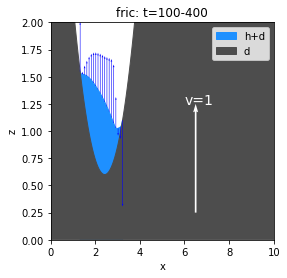

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.fill_between(Data_.x.data, Data_.h.sel(y=35, method='nearest').data+Data_.d_mean.sel(y=35, method='nearest').data, color='dodgerblue', label='h+d')
ax.fill_between(Data_.x.data, Data_.h.sel(y=35, method='nearest').data, color='0.3', label='d')
ax.quiver(Data_.x.data[::2], Data_.h.sel(y=35, method='nearest').data[::2]+Data_.d_mean.sel(y=35, method='nearest').data[::2], 0, Data_.v_mean.sel(y=35, method='nearest').data[::2],
          scale=1, scale_units='y', lw=4, color='b')
ax.set_xlim([0, 10])
ax.set_ylim([0, 2])
ax.quiver(6.5, 0.25, 0, 1,
          scale=1, scale_units='y', color='w')
ax.text(6,1.25, 'v=1', fontsize=14, color='w')
ax.set_title('fric: t=100-400')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.legend()
plt.savefig('../pics/rev3_2_2.jpg', dpi=300)

# Fig. 11

In [ ]:
yc = 35
yu = 30
yd = 40

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(3, 2, height_ratios=[.4, 1, 1], width_ratios=[.6, .3])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[-1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[-1, 1])

f1 = interp1d(Data_s0.y_out, Data_s0.x_out, bounds_error=False, fill_value=np.nan)
f2 = interp1d(Data_s4.y_out, Data_s4.x_out, bounds_error=False, fill_value=np.nan)

Data_.d_mean.sel(y=0, method='nearest').plot(ax=ax1, color='k', linestyle=':', lw=2, label='y = 0')
Data_.d_mean.sel(y=yu, method='nearest').plot(ax=ax1, color='k', lw=2, label=f'y = {yu}')
Data_.d_mean.sel(y=yc, method='nearest').plot(ax=ax1, color='0.5', lw=4, label=f'y = {yc}')
Data_.d_mean.sel(y=yd, method='nearest').plot(ax=ax1, color='k', linestyle='--', lw=2, label=f'y = {yd}')
ax1.plot(f1(yu),Data_.d_mean.interp(x=f1(yu), y = yu).data,'k^',markersize=10, label='$\Psi$ = -0.46')
ax1.plot(f1(yc),Data_.d_mean.interp(x=f1(yc), y = yc).data,'^',markersize=10, color='.5')
ax1.plot(f1(yd),Data_.d_mean.interp(x=f1(yd), y = yd).data,'^',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2)
ax1.plot(f2(yu),Data_.d_mean.interp(x=f2(yu), y = yu).data,'ko',markersize=10, label='$\Psi$ = -0.3')
ax1.plot(f2(yc),Data_.d_mean.interp(x=f2(yc), y = yc).data,'o',markersize=10, color='.5')
ax1.plot(f2(yd),Data_.d_mean.interp(x=f2(yd), y = yd).data,'o',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2)

Data_.PV_mean.sel(y=0, method='nearest').plot(ax=ax2, color='k', linestyle=':', lw=2)
Data_.PV_mean.sel(y=yu, method='nearest').plot(ax=ax2, color='k', lw=2)
Data_.PV_mean.sel(y=yc, method='nearest').plot(ax=ax2, color='0.5', lw=4,)
Data_.PV_mean.sel(y=yd, method='nearest').plot(ax=ax2, color='k', linestyle='--', lw=2)
ax2.plot(f1(yu),Data_.PV_mean.interp(x=f1(yu), y = yu).data,'k^',markersize=10, label=f'$\Psi$ = -0.46, y = {yu}')
ax2.plot(f1(yc),Data_.PV_mean.interp(x=f1(yc), y = yc).data,'^',markersize=10, color='.5', label=f'$\Psi$ = -0.46, y = {yc}')
ax2.plot(f1(yd),Data_.PV_mean.interp(x=f1(yd), y = yd).data,'^',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2, label=f'$\Psi$ = -0.46, y = {yd}')
ax2.plot(f2(yu),Data_.PV_mean.interp(x=f2(yu), y = yu).data,'ko',markersize=10)
ax2.plot(f2(yc),Data_.PV_mean.interp(x=f2(yc), y = yc).data,'o',markersize=10, color='.5')
ax2.plot(f2(yd),Data_.PV_mean.interp(x=f2(yd), y = yd).data,'o',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2)

Data_.Ber_mean.sel(y=0, method='nearest').plot(ax=ax3, color='k', linestyle=':', lw=2)
Data_.Ber_mean.sel(y=yu, method='nearest').plot(ax=ax3, color='k', lw=2)
Data_.Ber_mean.sel(y=yc, method='nearest').plot(ax=ax3, color='0.5', lw=4)
Data_.Ber_mean.sel(y=yd, method='nearest').plot(ax=ax3, color='k', linestyle='--', lw=2)
ax3.plot(f1(yu),Data_.Ber_mean.interp(x=f1(yu), y = yu).data,'k^',markersize=10)
ax3.plot(f1(yc),Data_.Ber_mean.interp(x=f1(yc), y = yc).data,'^',markersize=10, color='.5')
ax3.plot(f1(yd),Data_.Ber_mean.interp(x=f1(yd), y = yd).data,'^',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2)
ax3.plot(f2(yu),Data_.Ber_mean.interp(x=f2(yu), y = yu).data,'ko',markersize=10, label=f'$\Psi$ = -0.3, y = {yu}')
ax3.plot(f2(yc),Data_.Ber_mean.interp(x=f2(yc), y = yc).data,'o',markersize=10, color='.5', label=f'$\Psi$ = -0.3, y = {yc}')
ax3.plot(f2(yd),Data_.Ber_mean.interp(x=f2(yd), y = yd).data,'o',markersize=10, markerfacecolor="None", markeredgecolor='k', markeredgewidth=2, label=f'$\Psi$ = -0.3, y = {yd}')

S_ = np.arange(-.48,-.26,.02)
dq = np.zeros((2, len(S_)))
dB = np.zeros((2, len(S_)))
for i in range(len(S_)):
    x_out,y_out = project_streamline(x, y, Data_.Psi_mean.data, yc, S_[i])
    f_ = interp1d(y_out, x_out, bounds_error=False, fill_value=np.nan)
    dq[0, i] = Data_.PV_mean.interp(x=f_(yc), y = yc).data - Data_.PV_mean.interp(x=f_(yu), y = yu).data
    dq[1, i] = Data_.PV_mean.interp(x=f_(yd), y = yd).data - Data_.PV_mean.interp(x=f_(yc), y = yc).data
    dB[0, i] = Data_.Ber_mean.interp(x=f_(yc), y = yc).data - Data_.Ber_mean.interp(x=f_(yu), y = yu).data
    dB[1, i] = Data_.Ber_mean.interp(x=f_(yd), y = yd).data - Data_.Ber_mean.interp(x=f_(yc), y = yc).data

ax4.plot(S_, dq[0, :], 'k+', markersize=6, label='$()_{y=35} - ()_{y=30}$')
ax4.plot(S_, dq[1, :], 'kx', markersize=6, label='$()_{y=40} - ()_{y=35}$')

ax5.plot(S_, dB[0, :], 'k+', markersize=6)
ax5.plot(S_, dB[1, :], 'kx', markersize=6)

# predict dq following Pratt 1983
dq_predict = np.gradient(dB, S_, axis=1)
ax4.plot(S_, dq_predict[0,:], 'k-', lw = 2)
ax4.plot(S_, dq_predict[1,:], 'k-', lw = 2)
ax4.set_xlim([-0.5, -0.25])
ax4.set_ylabel(r'$\langle q \rangle$', fontsize=15)
ax4.set_xlabel('$\Psi$', fontsize=15)
ax4.grid(True)
ax4.text(-.48, -1.2, '(d)', fontsize=18)
ax4.legend(bbox_to_anchor=(.8, 1.2), loc='right')

ax5.set_xlim([-0.5, -0.25])
ax5.set_ylabel(r'$\langle B \rangle$', fontsize=15)
ax5.set_xlabel('$\Psi$', fontsize=15)
ax5.grid(True)
ax5.text(-.47, -.12, '(e)', fontsize=18)

ax1.set_xlim([.84, 3.84])
ax1.set_ylim([0, 1.4])
ax1.set_title('')
ax1.grid(True)
ax1.text(3.2, .7, '(a)', fontsize=18)
ax1.set_xlabel('x', fontsize=15)
ax1.set_ylabel('d', fontsize=15)
ax1.legend(bbox_to_anchor=(1.2, .5), loc='right')

ax2.set_xlim([.84, 3.84])
ax2.set_ylim([-5, 0])
ax2.set_title('')
ax2.grid(True)
ax2.text(3.2, -.8, '(b)', fontsize=18)
ax2.set_xlabel('x', fontsize=15)
ax2.set_ylabel('$q$', fontsize=15)
# ax2.legend(bbox_to_anchor=(1.35, .5), loc='right')

ax3.set_xlim([.84, 3.84])
ax3.set_ylim([.9, 1.7])
ax3.set_title('')
ax3.grid(True)
ax3.text(3.2, 1.6, '(c)', fontsize=18)
ax3.set_xlabel('x', fontsize=15)
ax3.set_ylabel('$B$', fontsize=15)
# ax3.legend(bbox_to_anchor=(1.35, .5), loc='right')

plt.tight_layout(pad=.1)
plt.savefig('../pics/Fig11.tif', dpi=1200)
plt.savefig('../pics/Fig11.eps')


# Fig. 12

In [ ]:
# energy_nofric from use Expnum = '11' and run the cells before individual figure plotting
energy_nofric = pd.read_csv('../data/energy_nofric.csv')
energy_nofric = energy_nofric.drop(columns="Unnamed: 0")

In [ ]:
Data_s2 = data_streamline(Data_, x, y, yc, S_2[idx_s2], False)        
Data_s4 = data_streamline(Data_, x, y, yc, S_4[idx_s4])

In [ ]:
x1 = np.median(x1_all)
y3 = np.median(y3_all)

from matplotlib import cm
cmap1=cm.RdBu_r
cmap1.set_bad('gray',1.)
cmap1.set_over('white',1.)

from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,1.3])

ax1 = plt.subplot(gs[:,0])
ax3 = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1])

Data_.Psi_mean.T.plot(cmap=cm.binary, vmin=-0.8, vmax=.2, levels=np.arange(-.8, .2+1e-4, 0.05, dtype=float), ax=ax1, cbar_kwargs={'label': ''}) # ,"aspect": 40,"shrink": 0.8, "pad":.1#, add_colorbar=False
ax1.plot(Data_s4.x_out,Data_s4.y_out,'w',linewidth=2)
ax1.plot(Data_s2.x_out,Data_s2.y_out,'w',linewidth=2)

a, idx_s1_s4 = find_nearest(Data_s4.x_out, x1)
a, idx_s1_s2 = find_nearest(Data_s2.x_out, x1)
ax1.plot(Data_s4.x_out[idx_s1_s4], Data_s4.y_out[idx_s1_s4], 'w.',markersize='16')
ax1.plot(Data_s2.x_out[idx_s1_s2], Data_s2.y_out[idx_s1_s2], 'w.',markersize='16') 
y1_ = np.arange(Data_s2.y_out[idx_s1_s2], Data_s4.y_out[idx_s1_s4]+1e-3, dy)
if y1_[-1]<Data_s4.y_out[idx_s1_s4]:
    y1_ = np.concatenate((y1_,Data_s4.y_out[idx_s1_s4].data.reshape(1,)))
x1_ = np.zeros(len(y1_),) + x1
ax1.plot(x1_,y1_,'w', linewidth=2)
a, idx_s3_s4 = find_nearest(Data_s4.y_out, y3)
a, idx_s3_s2 = find_nearest(Data_s2.y_out, y3)
ax1.plot(Data_s4.x_out[idx_s3_s4], Data_s4.y_out[idx_s3_s4], 'w.',markersize='16')
ax1.plot(Data_s2.x_out[idx_s3_s2], Data_s2.y_out[idx_s3_s2], 'w.',markersize='16')  
x3_ = np.arange(Data_s4.x_out[idx_s3_s4], Data_s2.x_out[idx_s3_s2]+1e-3, dx)
if x3_[-1]<Data_s2.x_out[idx_s3_s2]:
    x3_ = np.concatenate((x3_,Data_s2.x_out[idx_s3_s2].data.reshape(1,)))
y3_ = np.zeros(len(x3_),) + y3
ax1.plot(x3_,y3_,'w', linewidth=2)

ax1.text(3.5,23.5,'$S_1$',{'fontsize':16, 'color':'w'})
ax1.text(40,30,'$S_2$',{'fontsize':16, 'color':'w'})
ax1.text(20,48,'$S_3$',{'fontsize':16, 'color':'w'})
ax1.text(3.5,35,'$S_4$',{'fontsize':16, 'color':'k'})
ax1.set_xlabel('x', {'fontsize': 14})
ax1.set_ylabel('y', {'fontsize': 14})
ax1.set_title('$\Psi$', {'fontsize': 18})
 
import seaborn as sns
sns.set(style="whitegrid")
res3 = sns.barplot(data=energy, ci="sd", facecolor=".5", ax=ax3) # ci=68 error bar: standard error of the mean
ax3.set_yticks(np.around(np.arange(-.3, .3+1e-4, step=.1),1))
ax3.set_ylim([-.35,.35])
res3.set_xticklabels(res3.get_xmajorticklabels(), fontsize = 8)

res4 = sns.barplot(data=energy_nofric, ci="sd", facecolor=".5", ax=ax4) # ci=68 error bar: standard error of the mean
ax4.set_yticks(np.around(np.arange(-.3, .3+1e-4, step=.1),1))
ax4.set_ylim([-.35,.35])
res4.set_xticklabels(res4.get_xmajorticklabels(), fontsize = 8)

ax1.text(50,5,'(a)',{'fontsize':20, 'color':'w'})
ax1.set_xticklabels(ax1.get_xticks(), size = 14)
ax1.set_yticklabels(ax1.get_yticks(), size = 14)
ax3.set_title('(b) $Fric$', {'fontsize': 16})
ax4.set_title('(c) $No-Fric$', {'fontsize': 16})
ax1.set_aspect('equal', adjustable='box')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=25, fontsize=14)
ax3.set_yticklabels(ax3.get_yticks(), size = 14)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=25, fontsize=14)
ax4.set_yticklabels(ax4.get_yticks(), size = 14)
# plt.tight_layout(pad=0.4, w_pad=0, h_pad=.1)
plt.tight_layout(pad=0)

plt.savefig('../pics/Fig12.tif', dpi=300)
plt.savefig('../pics/Fig12.jpg', dpi=300)
plt.savefig('../pics/Fig12.eps')
